Consider the following nonlinear, autonomous system of ODEs:
$$
\frac{dx_1}{dt} = \frac{\alpha}{1 + x_2^\beta} - x_1 \\ 
\frac{dx_2}{dt} = \frac{\alpha}{1 + x_1^\beta} - x_2
$$
This model is known as the <i>two state toggle switch</i> model of a [gene regulatory network](https://en.wikipedia.org/wiki/Gene_regulatory_network). It models the gene expression levels $x_1$ and $x_2$ of two genes that repress the expression (i.e., transcription) of the other. This system was implemented experimentally by [Gardiner <i>et al.</i> (2000)](https://www.nature.com/articles/35002131). 

The parameter $\alpha > 0$ represents the production rate of the genes (assumed here to be equal for each gene for simplicity). The terms
$$
\frac{\alpha}{1 + x_2^\beta} \qquad \text{and}\qquad \frac{\alpha}{1 + x_1^\beta}
$$
are what are known as [<i>Hill functions</i>](https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)) in biochemistry. For example, the second term above accounts for the for the fact that multiple of the proteins encoded by gene 1 (transcription factors) may have to bind to the promoter region of gene 2 in order to repress its transcription. This property is called [<i>cooperativity</i>](https://en.wikipedia.org/wiki/Cooperativity) in biochemistry, and the <i>Hill coefficient</i> $\beta > 0$ represents the degree of cooperativity exhibited by the two genes.

Here, we will see how we can <b> numerically generate a phase portrait </b> of this system, complete with sample trajectories and classification of fixed points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
def toggleSwitch(t,x,A,B):
    return np.array([A/(1+x[1]**B) - x[0], A/(1+x[0]**B) - x[1]])

# define a truly autonomous version of above system - toggleSwitch "evaluated at" t=0, only a function of x,A,and B
def toggleFlow(x,A,B):
    return toggleSwitch(0,x,A,B)

First, we must pick some specific values for our parameters $\alpha$ and $\beta$. We will go with $\alpha = 1$ and $\beta = 2$.

In [3]:
a, b = (1,2)

Now, for numerical solution. Need: array of time points, initial condition(s). Use: solve_ivp function from SciPy ([RK45](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method).

In [14]:
timeVec = np.linspace(0,20,1000) # time points at which to store solution
timeSpan = (timeVec[0],timeVec[-1]) # timeSpan for solver - need to give it start and end points

# List of initial conditions:
inits = [(0.1,0.1),(0.1,1),(1,0.1),(0.5,0.1),(0.1,0.5),(1.9,1.9),(1.3,1),(1,1.3),(1.75,1),(1,1.75)]

# Numerical solution of the ODE via scipy.solve_ivp
from scipy.integrate import solve_ivp

trajectory = {}
for j,ic in enumerate(inits):
    mySol = solve_ivp(toggleSwitch, y0=ic, t_span = timeSpan, t_eval=timeVec, args = (a,b))
    trajectory[j] = mySol.y # get solution (x_1(t),x_2(t))

Visualization: start by plotting the component curves of the function.

(-0.05, 2.05)

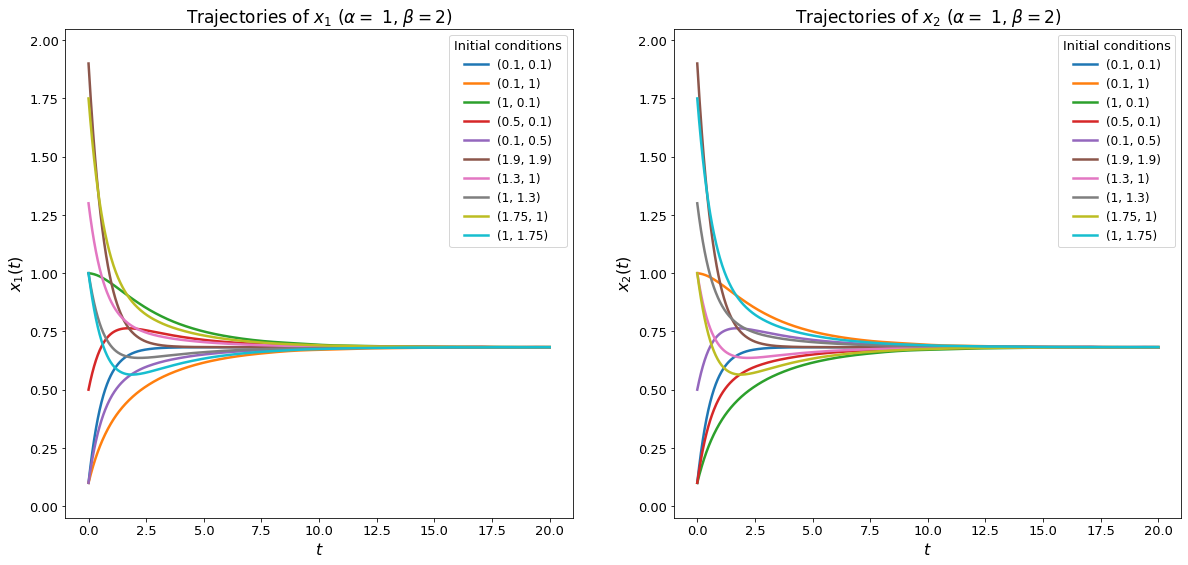

In [5]:
# Draw the component curves from the above solution
fig, ax = plt.subplots(1,2,figsize=(20,9))

for j,ic in enumerate(inits):
    L = ax[0].plot(timeVec,trajectory[j][0,:],linewidth=2.5, label=ic)
    ax[1].plot(timeVec,trajectory[j][1,:],linewidth=2.5, color=L[0].get_color(),label=ic)

ax[0].set_xlabel(r"$t$",fontsize=16)
ax[0].set_ylabel(r"$x_1(t)$",fontsize=16)
ax[0].tick_params(labelsize=13)
ax[0].set_title(r"Trajectories of $x_1$ ($\alpha = $ "+str(a) + r", $\beta =$"+str(b)+")",fontsize=17)
ax[0].legend(title='Initial conditions',title_fontsize=13,fontsize=12)
ax[0].set_ylim([-0.05,2.05])

ax[1].set_xlabel(r"$t$",fontsize=16)
ax[1].set_ylabel(r"$x_2(t)$",fontsize=16)
ax[1].tick_params(labelsize=13)
ax[1].set_title(r"Trajectories of $x_2$ ($\alpha = $ "+str(a) + r", $\beta =$"+str(b)+")",fontsize=17)
ax[1].legend(title='Initial conditions',title_fontsize=13,fontsize=12)
ax[1].set_ylim([-0.05,2.05])

Fixed points located at the intersection of the two nullclines:
$$
x_1 = \frac{\alpha}{1+ x_2^\beta} \quad\mbox{and}\qquad x_2 = \frac{\alpha}{1 + x_1^\beta} ~.
$$
To start, let's plot them.

Text(0, 0.5, '$x_2$')

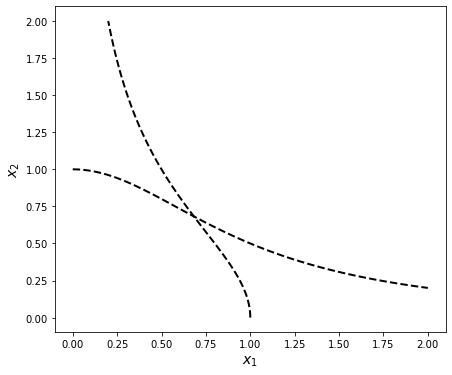

In [7]:
x1vec = np.linspace(0,2,100)
x2vec = np.linspace(0,2,100)

myFig = plt.figure(figsize=(7,6))

plt.plot(x1vec, a/(1+x1vec**b),'k--',linewidth=2)
plt.plot(a/(1+x2vec**b),x2vec,'k--',linewidth=2)

plt.xlabel(r"$x_1$",fontsize=14)
plt.ylabel(r"$x_2$",fontsize=14)

To find their intersection numerically, we will define a Python function that finds the roots of a function $f(x)$, i.e., $x$ such that $f(x) = 0$. We can use the built-in SciPy function `fsolve` function. This function uses a [root finding algorithm](https://en.wikipedia.org/wiki/Root-finding_algorithms), which requires us to input an initial guess for the value of the root. The following function mainly calls `fsolve`, and with a few additional lines so that we don't get error message if a root isnt found (i.e., if the algorithm does not <i> converge</i>).

In [1]:
from scipy.optimize import fsolve # import fsolve function from optimize package in SciPy

def findroot(func, init, param = 0): 
    """ Find roots of nonlinear equation func(x)=0 using initial guesses init (list or np.array).
    The optional input param is in case func takes in additional arguments other than x.
    Args:
        - the system (function func),
        - the initial values (list or np.array)
        - optional parameter inputs param

    return: roots of f(x) (np.array) if the numerical method converges (else, return nan)
    """
    sol, info, convergence, sms = fsolve(func, init, args = param, full_output=True)
    if convergence == 1: # if 'convergence' = 1, this means fsolve found a root
        return sol
    return np.array([np.nan]*len(init))

Find the fixed point of the toggle switch using $(0.75,0.75)$ as our initial guess:

In [9]:
my_fp = findroot(toggleFlow, np.array([0.75,0.75]), param = (a,b))

Add the fixed point to existing plot of the nullclines:

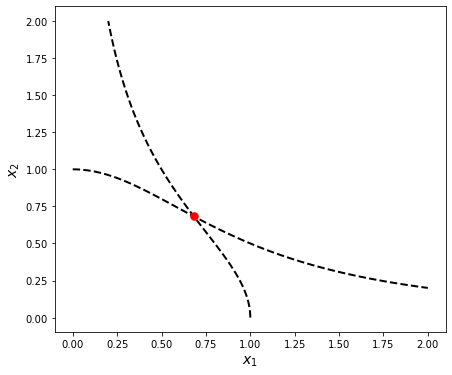

In [10]:
myAxes = myFig.gca() # retrive our previous plot - gca = "get current Axes"
myAxes.plot(my_fp[0],my_fp[1],'r.',markersize=15) # add fixed point to plot
myFig # show plot

Add in direction field using `quiver` function in Python:

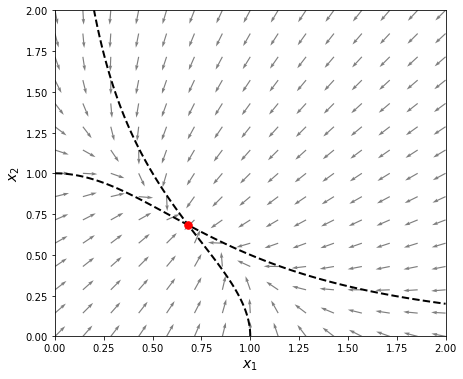

In [11]:
X1,X2 = np.meshgrid(np.linspace(0,2,15),np.linspace(0,2,15))
f = toggleFlow([X1,X2],a,b)
f = f/np.sqrt(f[0]**2 + f[1]**2) # normalize vectors
myAxes.quiver(X1,X2,f[0],f[1],width=0.003,alpha=0.5)

myAxes.set_xlim([x1vec.min(),x1vec.max()])
myAxes.set_ylim([x2vec.min(),x2vec.max()])

myFig

Finally, let's add in the trajectories we found earlier:

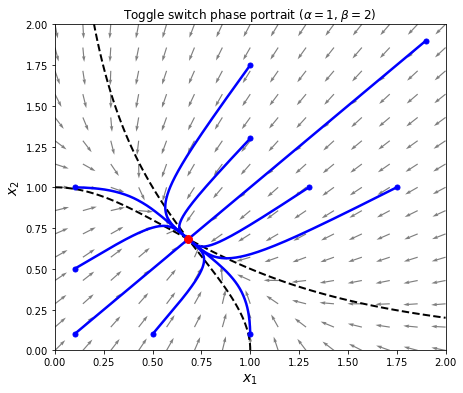

In [12]:
for j,ic in enumerate(inits):
    myAxes.plot(ic[0],ic[1],'b.',markersize=10)
    myAxes.plot(trajectory[j][0,:],trajectory[j][1,:], 'b-',linewidth=2.5)

myAxes.plot(my_fp[0],my_fp[1],'r.',markersize=15)

myAxes.set_title(r"Toggle switch phase portrait ($\alpha = $"+str(a)+r", $\beta = $"+str(b)+')')

myFig

What about determining stability of the fixed points? For nonlinear systems, we can classify stability using the eigenvalues of the <i>Jacobian matrix</i> of $\vec{f}(x_1,x_2)$ evaluated at the fixed point, similar to how we did for linear systems:
$$
J(x_1^*,x_2^*) = \begin{pmatrix} \displaystyle \frac{\partial f_1}{\partial x_1}(x_1^*,x_2^*) & \displaystyle \frac{\partial f_1}{\partial x_2}(x_1^*,x_2^*) \\[2ex] \displaystyle \frac{\partial f_2}{\partial x_1}(x_1^*,x_2^*) & \displaystyle \frac{\partial f_2}{\partial x_2}(x_1^*,x_2^*) \end{pmatrix}
$$
(See the "Linear Stability Analysis" supplementary notes for more information.)

For this example, we could compute the Jacobian exactly. However, for the sake of building a more general module for generating phase portraits, we will approximate the Jacobian numerically using the `numdifftools` package in Python.

In [28]:
import numdifftools as nd

# following line defines J(x) as a function of x
toggleJacobian = nd.Jacobian(lambda x: toggleFlow(x,a,b)) # define in-line function of flow evaluated at parameter values
J = toggleJacobian(my_fp) # evaluate J(x) at the only fixed point
J 

array([[-1.        , -0.63534439],
       [-0.63534439, -1.        ]])

Recall that the eigenvalues of a 2x2 matrix $A = \begin{pmatrix}
a & b \\ c & d
\end{pmatrix}$ are given by:
$$
\lambda_{1,2} = \frac{\text{tr}(A) \pm \sqrt{\text{tr}(A)^2 - 4 \text{det}(A)}}{2},
$$
where $\text{tr}(A) = a + d$ and $\text{det}(A) = ad-bc$. Using this formula, we can actually show that
$$
\text{tr}(A) = \lambda_1 + \lambda_2 \qquad \text{and}\qquad \text{det}(A) = \lambda_1\lambda_2
$$
We can use these facts to simplify how we check the different cases of the eigenvalues of the Jacobian as they relate to the type/stability of the fixed point.

In [34]:
def findStability(J):
    """ Determines stability of a fixed point given its associated 2x2 Jacobian matrix. 
    Args:
        J (np.array 2x2): the Jacobian matrix at the fixed point.
    Return:
        nature (string): classification of equilibrium point 
    """
    detJ = np.linalg.det(J)
    trJ = np.trace(J)
    if np.isclose(trJ,0) and detJ>0: # complex eigenvalues with real part = 0 -> center
        nature = "Center"
    elif detJ < 0: # product of the eigenvalues < 0 -> different signs -> saddle point
        nature = "Saddle point"
    else:
        nature = "Stable" if trJ < 0 else "Unstable" # if detJ > 0 and tr(J) =/= 0, stability depends on sign of tr(J)
        nature += " spiral" if (trJ**2 < 4*detJ) else " node" # spiral if eigenvalues are complex, node else
    return nature

In [35]:
findStability(J)

'Stable node'